Author: Noah Lee

Abstract:

In this notebook, we are tasked with classifying a random image as either a horse or a human, given a dataset of ~1200 total images. Each image of a horse or human is 300 by 300 pixels, and contains 3 channels for the RGB values. Our approach is as follows: We first augment the training data by converting the images to grayscale and then randomly rotating, flipping, and cropping. We create and train a custom CNN based off of a simplified VGG16 model architecture. It combines convolution, max pooling and ReLU activations to create features from the image, then classifies the features with two fully connected layers and dropout. We train the model with batches of 200 images and implement a function for a user to upload and classify random images.

Steps to Run:
1. Switch runtime to GPU. This will massively speed up the model's training time.
2. Run all cells.
3. Upload the dataset, Deep_learning dataset-20201001T200102Z-001.zip, from local storage.
4. To test the model on random images, upload random individual images to the test_model function or pass a directory containing images.

The overall time to run this notebook will be about 30 minutes. ~20 to upload the dataset to Google Colab, and ~10 minutes to train the model.

In [ ]:
# Run this code snippet if the dataset has not been uploaded to Google Colab yet
# Upload the dataset from local: Deep_learning dataset-20201001T200102Z-001.zip

from google.colab import files
files.upload() # Upload Deep_learning dataset-20201001T200102Z-001.zip
!unzip "Deep_learning dataset-20201001T200102Z-001.zip" -d data/

Saving Deep_learning dataset-20201001T200102Z-001.zip to Deep_learning dataset-20201001T200102Z-001.zip
Archive:  Deep_learning dataset-20201001T200102Z-001.zip
  inflating: data/Deep_learning dataset/test-horse-or-human/test/Aishwaraya.jpg  
  inflating: data/Deep_learning dataset/validation-horse-or-human/horses/horse2-201.png  
  inflating: data/Deep_learning dataset/validation-horse-or-human/horses/horse5-203.png  
  inflating: data/Deep_learning dataset/validation-horse-or-human/horses/horse2-582.png  
  inflating: data/Deep_learning dataset/validation-horse-or-human/horses/horse1-298.png  
  inflating: data/Deep_learning dataset/validation-horse-or-human/horses/horse5-550.png  
  inflating: data/Deep_learning dataset/test-horse-or-human/test/Modi.jpg  
  inflating: data/Deep_learning dataset/validation-horse-or-human/horses/horse1-224.png  
  inflating: data/Deep_learning dataset/validation-horse-or-human/horses/horse1-455.png  
  inflating: data/Deep_learning dataset/validation-

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import os
import random
import time
import copy
from PIL import Image

In [ ]:
SEED = 37

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
data_path = os.path.join("data", "Deep_learning dataset")
train_dir = os.path.join(data_path, "horse-or-human")
val_dir = os.path.join(data_path, "validation-horse-or-human")
test_dir = os.path.join(data_path, "test-horse-or-human", "test")

In [ ]:
# Calculate means and stds for normalizing data
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.ToTensor())
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means = means / len(train_data)
stds = means / len(train_data)
    
print("Calculated means:", means)
print("Calculated stds:", stds)

Calculated means: tensor([0.5505, 0.5140, 0.4942])
Calculated stds: tensor([0.0005, 0.0005, 0.0005])


In [ ]:
preferred_img_size = (224,224)

train_transforms = transforms.Compose([
                           transforms.Resize(preferred_img_size),
                           transforms.Grayscale(3),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomVerticalFlip(0.5),
                           transforms.RandomCrop(preferred_img_size, 
                                                 padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, std = stds)
                       ])

validation_transforms = transforms.Compose([
                                transforms.Resize(preferred_img_size),
                                transforms.Grayscale(3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = means, std = stds)
                            ])

test_transforms = validation_transforms

In [ ]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)
val_data = datasets.ImageFolder(root = val_dir, 
                                transform = validation_transforms)

In [ ]:
print("# of training images:", len(train_data))
print("# of validation images:", len(val_data))

# of training images: 1027
# of validation images: 256


In [ ]:
BATCH_SIZE = 200

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

val_iterator = data.DataLoader(val_data, 
                               batch_size = BATCH_SIZE)

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):
        
        super().__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 1),    #(b,3,224,224)->(b,64,224,224)
            nn.MaxPool2d(2),                     #(b,64,224,224)->(b,64,112,112)
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 128, 3, padding = 1),  #(b,64,112,112)->(b,128,112,112)
            nn.MaxPool2d(2),                     #(b,128,112,112)->(b,128,56,56)
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, 3, padding = 1), #(b,128,56,56)->(b,256,56,56)
            nn.MaxPool2d(2),                     #(b,256,56,56)->(b,256,28,28)
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 512, 3, padding = 1), #(b,256,28,28)->(b,512,28,28)
            nn.MaxPool2d(2),                     #(b,512,28,28)->(b,512,14,14)
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1), #(b,512,14,14)->(b,512,14,14)
            nn.MaxPool2d(2),                     #(b,512,14,14)->(b,512,7,7)
            nn.ReLU(inplace = True)
        )

        self.linear = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(512 * 7 * 7, 1024),      #(b,25088)->(b,1024)
            nn.ReLU(inplace = True),
            nn.Dropout(0.6),
            nn.Linear(1024, 512),               #(b,1024)->(b,512)  
            nn.ReLU(inplace = True),
            nn.Linear(512, 2)                   #(b,512)->(b,2)
        )

    def forward(self, x):
        x = self.convolutional(x)                #(b,3,224,224)->(b,512,7,7)
        flat = x.view(x.shape[0], -1)            #(b,512,7,7)->(b,25088)
        x = self.linear(flat)                    #(b,25088)->(b,2)
        return x

In [ ]:
model = ConvNet()
def print_parameters(model):
    ''' Print the parameters of the model and the total number of parameters.

        Args:
            model (ConvNet): A simple convolutional neural network made with
                             Pytorch.
    '''
    print("Name", "# Params")
    sum = 0
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        print(name, param.numel())
        sum += param.numel()
    print("Total trainable parameters:", sum)

print(model)
print_parameters(model)

ConvNet(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU(inplace=True)
  )
  (linear)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.CrossEntropyLoss()

model = model.to(device)

loss_fn = loss_fn.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    '''
        Calculate the number of correct y predictions divided by the total
        number of predictions.

        Args:
            y_pred (torch.Tensor): A (Nx2) tensor, each row contains the 
                                   prediction of the model for a horse vs.
                                   a human.
            y (torch.Tensor): A (N,) tensor containing the true classes for each
                              image.
        Returns:
            acc (float): The proportion of correct predictions over total
                         predictions.
    '''
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, computes error,
        and updates model weights.

        Args:
            model (ConvNet): The CNN to perform weight updates on.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            optimizer (optim): Learning rate optimizer for individual parameters
            loss_fn: Computes loss and gradient descent for model parameters
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, and computes loss
        and accuracy.

        Args:
            model (ConvNet): The CNN model to make predictions.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            loss_fn: Computes loss for predicted values and actual values
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    '''
        Converts a given start time and end time into a duration in min:sec
        format.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 40

best_loss = float('inf')
best_model = None

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, loss_fn, device)
        
    if valid_loss <= best_loss:
        best_loss = valid_loss
        best_model = copy.deepcopy(model.state_dict())

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print("Epoch:", epoch+1, "| Epoch Time:", epoch_mins, "m ", epoch_secs,"s")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
torch.save(best_model, 'conv-model.pt')

Epoch: 1 | Epoch Time: 0 m  15 s
	Train Loss: 81.902 | Train Acc: 49.06%
	 Val. Loss: 0.716 |  Val. Acc: 32.00%
Epoch: 2 | Epoch Time: 0 m  15 s
	Train Loss: 0.713 | Train Acc: 54.96%
	 Val. Loss: 0.580 |  Val. Acc: 68.00%
Epoch: 3 | Epoch Time: 0 m  15 s
	Train Loss: 0.736 | Train Acc: 54.61%
	 Val. Loss: 0.646 |  Val. Acc: 86.00%
Epoch: 4 | Epoch Time: 0 m  15 s
	Train Loss: 0.655 | Train Acc: 64.58%
	 Val. Loss: 0.523 |  Val. Acc: 77.25%
Epoch: 5 | Epoch Time: 0 m  15 s
	Train Loss: 0.628 | Train Acc: 64.98%
	 Val. Loss: 0.420 |  Val. Acc: 91.50%
Epoch: 6 | Epoch Time: 0 m  15 s
	Train Loss: 0.580 | Train Acc: 71.43%
	 Val. Loss: 0.293 |  Val. Acc: 91.25%
Epoch: 7 | Epoch Time: 0 m  15 s
	Train Loss: 0.518 | Train Acc: 75.68%
	 Val. Loss: 0.288 |  Val. Acc: 91.75%
Epoch: 8 | Epoch Time: 0 m  15 s
	Train Loss: 0.461 | Train Acc: 79.00%
	 Val. Loss: 0.285 |  Val. Acc: 93.00%
Epoch: 9 | Epoch Time: 0 m  15 s
	Train Loss: 0.504 | Train Acc: 77.61%
	 Val. Loss: 0.287 |  Val. Acc: 90.75%


In [ ]:
model.load_state_dict(torch.load('conv-model.pt'))

val_loss, val_acc = evaluate(model, val_iterator, loss_fn, device)

print(f'Best Validation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')

Best Validation Loss: 0.246 | Validation Acc: 94.00%


In [ ]:
def test_model(directory=None):
    '''
        Evaluates the best model trained on images given via user upload or in
        a directory.
    '''
    model = ConvNet()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load('conv-model.pt'))
    model.to(device)
    model.eval()

    if directory is not None:
        test_imgs = os.listdir(directory)
    else:
        test_imgs = files.upload().keys()
    working_dir = directory if directory is not None else os.getcwd()
    rgb_imgs = [Image.open(os.path.join(working_dir, im_name)).convert("RGB")\
                for im_name in test_imgs]
    tensors = [test_transforms(img) for img in rgb_imgs]

    fig, axs = plt.subplots(len(tensors), squeeze=False, figsize=(20,20))
    fig.tight_layout()

    for i in range(len(tensors)):
        x = tensors[i]
        x = x.unsqueeze(0)
        x = x.to(device)
        y_pred = model(x)
        if y_pred[0][0] > y_pred[0][1]:
            axs[i,0].set_title("Horse")
        else:
            axs[i,0].set_title("Human")
        axs[i,0].imshow(np.asarray(rgb_imgs[i]))
       

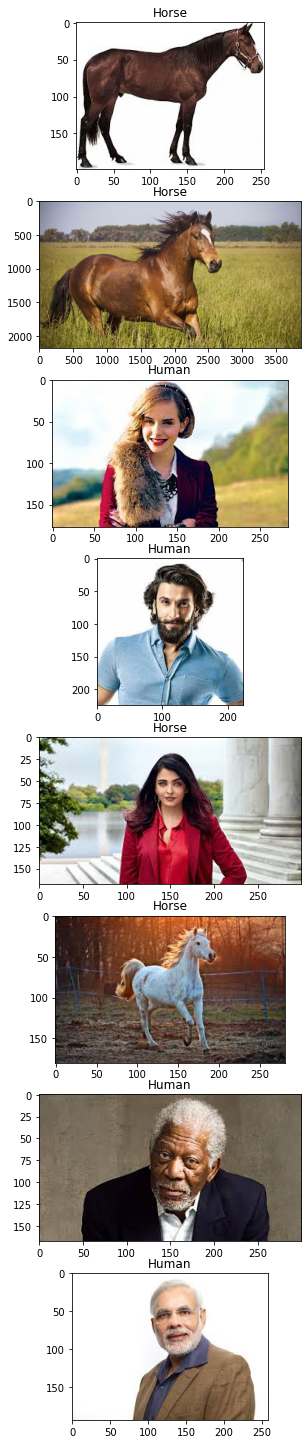

In [ ]:
test_model(test_dir)

In [ ]:
test_model()

MessageError: ignored

Conclusion:

We trained a simple convolutional neural network on batches of 200 images. We utilize the Adam optimizer with a maximum learning rate of 1e-3 to update learning rates, and the Cross Entropy Loss function for our loss function. Within 40 epochs of training, we are able to see the model converge to a loss of 0.246 and an accuracy of 94.00% on the validation set.

I wrote the code to preprocess the data, the code for the model, and the code to upload and test the model on images. For the other code to train the model I drew heavily upon examples from the internet, since the training loop is common and very similar among all CNNs.